In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 20
eps_sublevel = 0.2
percent = 0.2

rho = 1 
res_type="primal"

num_resources = 50
num_agents = num_participants = 10

filename = "admm_resal_N%d_%.2f_n%d_m%d_%s"%(num_points, eps_sublevel, num_agents, num_resources, res_type)

In [4]:
num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

In [5]:
b_norm = 1

In [6]:
E, consensus2agent, agent2consensus, E_g = mra.resal_admm_matrices(num_agents, num_resources, A_ineq, A_all)

public_var_size = len(consensus2agent)
private_var_size = sum([agent2consensus[i].size for i in range(num_agents + 1)])
print(f"{public_var_size=}, {private_var_size=}")

public_var_size=500, private_var_size=1000


# CVXPY centralized solution

In [7]:
true_x, true_f, true_lamb  = mra.centralized_solution_resal_admm(A_all, E, A_ineq, b_ineq, E_g)
print(f"{true_f=}")

true_f=-9.69894175254799


In [8]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

2.0

In [9]:
true_x.shape, true_lamb.shape

((1000, 1), (1000, 1))

In [10]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_query_eps_o(lamb_k, z_k, i, A_all, rho,
                                                                           eps_sublevel=eps_sublevel, num_points=K, E_g=E_g)]
    fun_agents_noisy_y += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_query_noisy_price_percent(lamb_k, z_k, i, A_all, rho,
                                                                        percent=percent, num_points=K, E_g=E_g)]
    
fun_agents_eps += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_g_query_eps_o(lamb_k, z_k, A_ineq, b_ineq, E_g, rho, 
                                                                           eps_sublevel=eps_sublevel, num_points=K)]
fun_agents_noisy_y += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_g_query_noisy_price_percent(lamb_k, z_k, A_ineq, b_ineq, E_g, rho,
                                                                        percent=percent, num_points=K)]

fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# ADMM

In [11]:
K_i = num_points

In [12]:
all_results_eps, lamb_k_eps, x_k, _, mra_xk_eps  = mra.admm_consensus(fun_agents_eps, fun_obj_val, agent2consensus, consensus2agent, E, 
                                                            rho=rho, postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=5, eps_res=1e-8,
                                                            res_type=res_type, history=1)


all_results_noisy_y, lamb_k_eps, x_k, _, mra_xk_noisy_y  = mra.admm_consensus(fun_agents_noisy_y, fun_obj_val, 
                                                            agent2consensus, consensus2agent, E, 
                                                            rho=rho, postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=5, eps_res=1e-8,
                                                            res_type=res_type, history=1)

VIOLATION: 0.00031192695212400867, 0=
epoch=0, f_subopt_xk=3.7971E-02,  f_subopt_mra=1.3674E-01,  viol_prim_xk=7.0659E-01,  viol_prim_mra=7.0690E-01, rel_res=1.7081E+00, 9.3956E-01
epoch=5, f_subopt_xk=8.8602E-03,  f_subopt_mra=9.1803E-03,  viol_prim_xk=1.4977E-03,  viol_prim_mra=8.4318E-04, rel_res=2.2829E-01, 2.2618E-03
epoch=10, f_subopt_xk=3.6013E-03,  f_subopt_mra=6.3425E-03,  viol_prim_xk=1.4892E-02,  viol_prim_mra=7.2283E-03, rel_res=1.0325E-01, 2.3072E-02
epoch=15, f_subopt_xk=2.9388E-03,  f_subopt_mra=3.2585E-03,  viol_prim_xk=4.5828E-03,  viol_prim_mra=3.3629E-03, rel_res=4.2642E-02, 3.9344E-03
epoch=20, f_subopt_xk=2.3411E-03,  f_subopt_mra=2.4029E-03,  viol_prim_xk=5.1421E-04,  viol_prim_mra=2.8799E-04, rel_res=3.8489E-02, 7.0614E-04
epoch=25, f_subopt_xk=1.8227E-03,  f_subopt_mra=1.8285E-03,  viol_prim_xk=3.5889E-05,  viol_prim_mra=1.7947E-05, rel_res=3.7974E-02, 4.5482E-05
epoch=30, f_subopt_xk=1.4133E-03,  f_subopt_mra=2.1053E-03,  viol_prim_xk=5.7157E-03,  viol_prim_mra

/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


epoch=0, f_subopt_xk=3.7972E-02,  f_subopt_mra=3.7972E-02,  viol_prim_xk=7.0659E-01,  viol_prim_mra=7.0659E-01, rel_res=1.7081E+00, 0.0000E+00
VIOLATION: 0.0005954551020550254, 1=
epoch=5, f_subopt_xk=8.8620E-03,  f_subopt_mra=9.1146E-03,  viol_prim_xk=1.4889E-03,  viol_prim_mra=1.8672E-07, rel_res=2.2825E-01, 1.6334E-02
epoch=10, f_subopt_xk=3.6022E-03,  f_subopt_mra=3.7588E-03,  viol_prim_xk=1.4887E-02,  viol_prim_mra=4.5068E-03, rel_res=1.0322E-01, 2.1056E-02
epoch=15, f_subopt_xk=2.9389E-03,  f_subopt_mra=2.8596E-03,  viol_prim_xk=4.5839E-03,  viol_prim_mra=6.6366E-09, rel_res=4.2644E-02, 8.4497E-03
epoch=20, f_subopt_xk=2.3411E-03,  f_subopt_mra=2.3458E-03,  viol_prim_xk=5.1455E-04,  viol_prim_mra=7.7753E-09, rel_res=3.8490E-02, 3.1170E-03
epoch=25, f_subopt_xk=1.8228E-03,  f_subopt_mra=1.8529E-03,  viol_prim_xk=3.6658E-05,  viol_prim_mra=4.1901E-08, rel_res=3.7974E-02, 1.5698E-02
epoch=30, f_subopt_xk=1.4134E-03,  f_subopt_mra=1.5055E-03,  viol_prim_xk=5.7116E-03,  viol_prim_mra=

In [13]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [14]:
T = 500

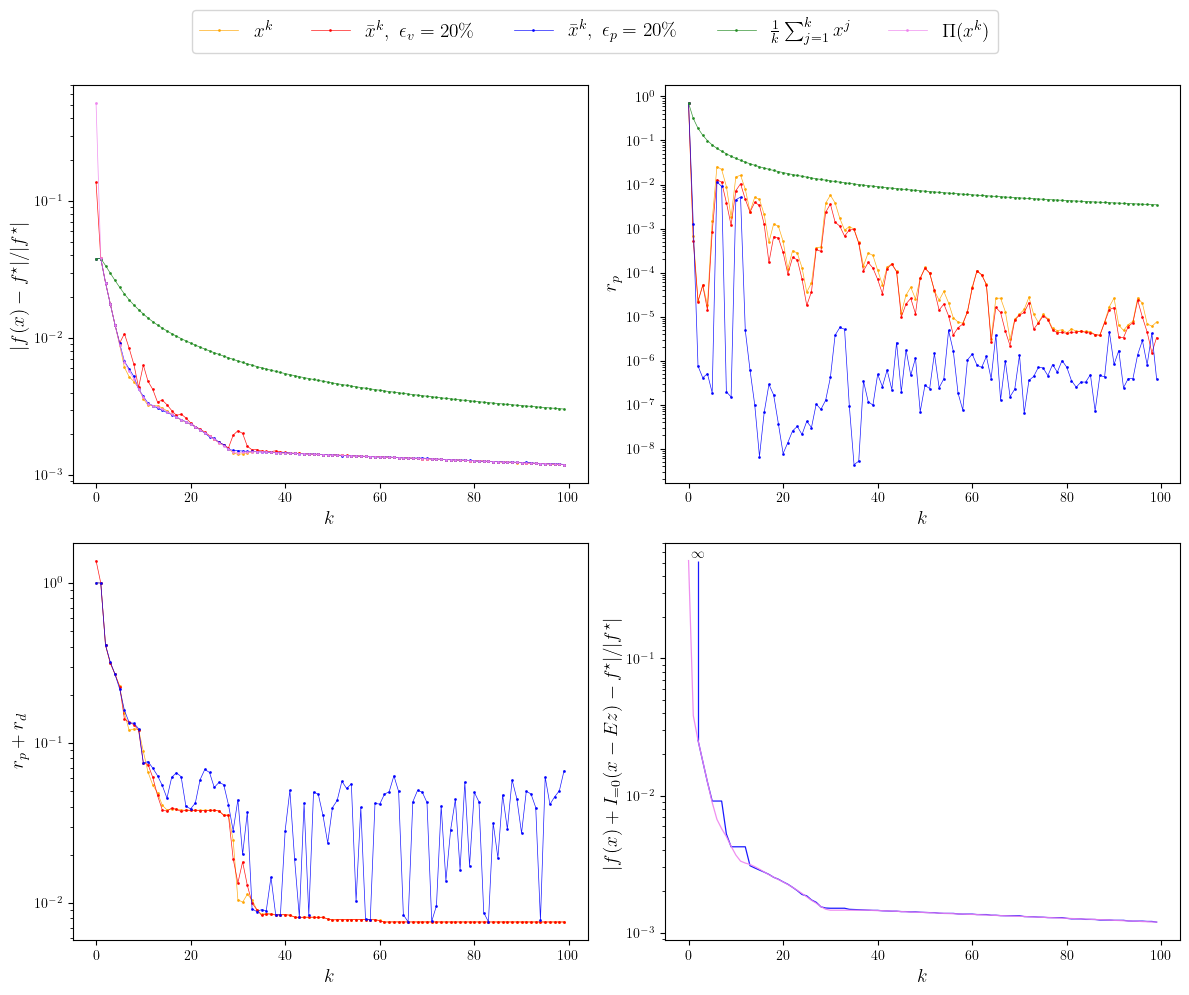

In [15]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T, admm=True)

T=500
0.0011908799387884792 sub_eps 0.0011930883243080862 noisy_y 0.0011923719766937907 proj 0.001193318423597341


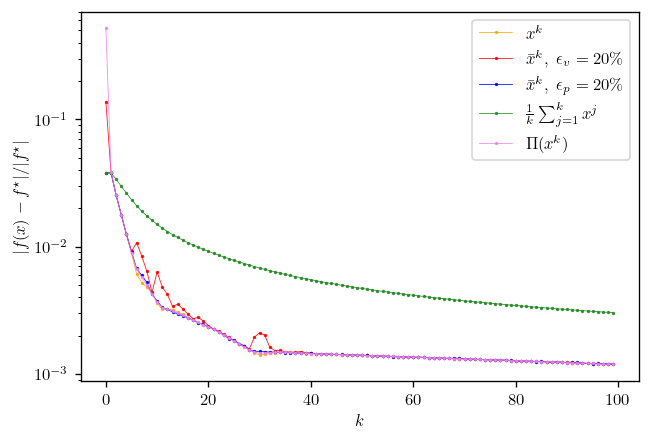

In [16]:
mra.plot_func_subopt_all(all_res, all_results_eps, all_results_noisy_y, true_f, eps_sublevel, percent, 
                        filename=filename, T=T)

In [17]:
print(np.array(all_res["viol_primal_xk"])[-1],
      "sub_eps", np.array(all_results_eps["viol_primal_mra_xk"])[-1],
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"])[-1])

7.546911654261075e-06 sub_eps 3.350301234481804e-06 noisy_y 3.8444419914214023e-07


In [18]:
print("sub_eps", np.array(all_results_eps["viol_primal_mra_xk"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"]).size)

sub_eps 100 noisy_y 100


T=500
7.546911654261075e-06 sub_eps 3.350301234481804e-06 noisy_y 3.8444419914214023e-07


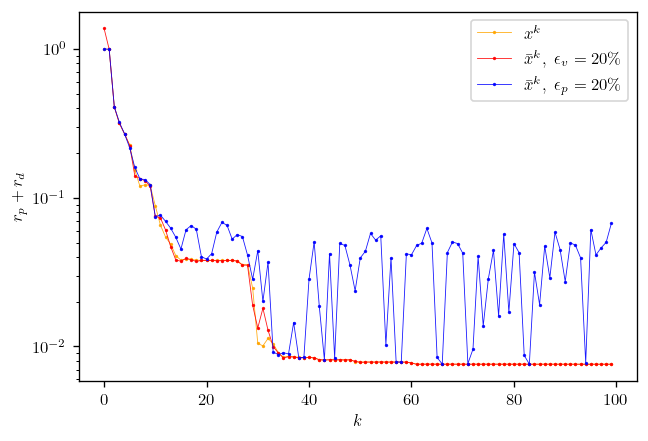

In [19]:
mra.plot_prim_complem_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                               filename=filename, T=T, admm=True)

T=500
7.546911654261075e-06 sub_eps 3.350301234481804e-06 noisy_y 3.8444419914214023e-07


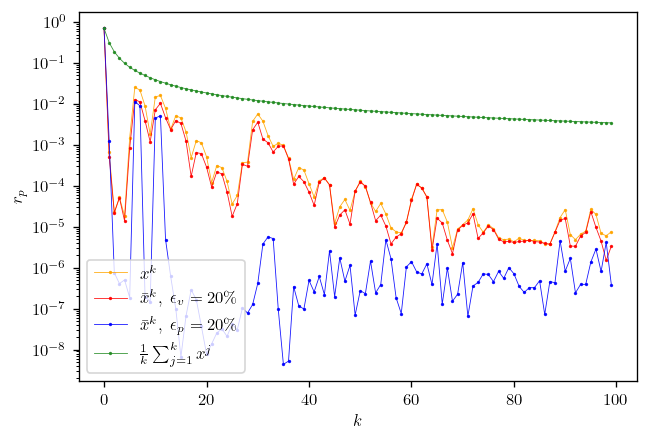

In [20]:
mra.plot_prim_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                       filename=filename, T=T, admm=True)

T=500


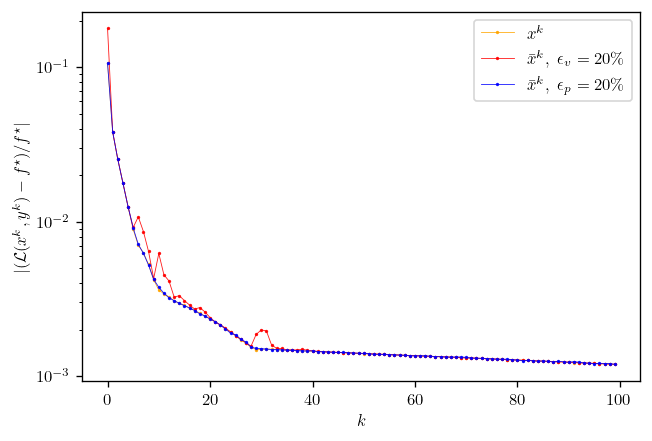

In [21]:
mra.plot_lagr_subopt_all(all_res, all_results_eps, all_results_noisy_y, eps_sublevel, percent, true_f=true_f,
                        filename=filename, T=T)

In [22]:
# T = 100
# idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
# idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
# idx_noisy_y = np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]
# idx_eps = 25#np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]

# print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

# print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
#     "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
#     "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
#     "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
#     "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

# print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
#       "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
#       "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
#       "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

In [23]:
# import pickle

# with open(f"../results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
# with open(f"../results/{filename}_dict.pkl", "rb") as file:
#     res = pickle.load(file)
